<a href="https://colab.research.google.com/github/v-artur/Golden_Oreos/blob/main/Modeling1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Install some of the dependencies

In [ ]:
%%capture
!pip install fastdtw
!pip install pysptk      
!pip install pyworld

Import files from Google drive

In [ ]:
#old links, because gdown is not reliable on the long run
#!pip install gdown
#!gdown https://drive.google.com/uc?id=1Uu55cqiSZLCj0fAU7QoXxJSIunsuqHEX
#!gdown https://drive.google.com/u/0/uc?id=1_eeG0d_r-RqazUkr-ZRPNC6L13sHYwIP
#!gdown https://drive.google.com/u/0/uc?id=1Bjf3ncRe8CcWHl3i0HxRo4unRYkz2fog


#the data
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1vtZchVzl424pSQBXQ8EBxvVOzcEQPKIp' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1vtZchVzl424pSQBXQ8EBxvVOzcEQPKIp" -O features.zip && rm -rf /tmp/cookies.txt
#reconstruction module
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1_eeG0d_r-RqazUkr-ZRPNC6L13sHYwIP' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1_eeG0d_r-RqazUkr-ZRPNC6L13sHYwIP" -O reconstructWave.py && rm -rf /tmp/cookies.txt
#Melfiltebank applier
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1Bjf3ncRe8CcWHl3i0HxRo4unRYkz2fog' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1Bjf3ncRe8CcWHl3i0HxRo4unRYkz2fog" -O MelFilterBank.py && rm -rf /tmp/cookies.txt


#extracting it
import zipfile
zip_ref = zipfile.ZipFile("/content/features.zip", 'r')
zip_ref.extractall("/content/features")
zip_ref.close()

#creating folders for the synthesized audiofiles for the best model and all model types
!mkdir synth_audio    #this one is for the best model, that will be trained and tested on all participants

#these 2 folders will be needed for the evaluation of each model type
!mkdir synth_audio_bn        #bottleneck
!mkdir synth_audio_dnn       #FC-DNN
!mkdir synth_audio_bigru     #BiGRU 

--2022-11-26 15:07:05--  https://docs.google.com/uc?export=download&confirm=t&id=1vtZchVzl424pSQBXQ8EBxvVOzcEQPKIp
Resolving docs.google.com (docs.google.com)... 142.250.4.102, 142.250.4.113, 142.250.4.101, ...
Connecting to docs.google.com (docs.google.com)|142.250.4.102|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-08-9o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/mk960r7v7pp8eprg41c2tvlrmfdl8t32/1669475175000/17895932938140350971/*/1vtZchVzl424pSQBXQ8EBxvVOzcEQPKIp?e=download&uuid=37ca7adf-5970-46d2-9856-3ff7256d2c98 [following]
--2022-11-26 15:07:05--  https://doc-08-9o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/mk960r7v7pp8eprg41c2tvlrmfdl8t32/1669475175000/17895932938140350971/*/1vtZchVzl424pSQBXQ8EBxvVOzcEQPKIp?e=download&uuid=37ca7adf-5970-46d2-9856-3ff7256d2c98
Resolving doc-08-9o-docs.googleusercontent.com (doc-08-9o-docs.googleusercontent.com)... 142.250.4.132, 2404:

Necessary models and functions

In [ ]:
import tensorflow as tf
from tensorflow.keras import regularizers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Dense, Dropout, Input, Bidirectional, GRU, Flatten
import numpy as np


#Bottleneck FC-DNN

def create_bottleneck_model(inputsize, outputsize):
    model = tf.keras.Sequential()
    model.add(Input(shape=(inputsize)))
    model.add(Dense(128, activation="relu", kernel_initializer='HeNormal'))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation="relu", kernel_initializer='HeNormal'))
    model.add(Dropout(0.2))
    model.add(Dense(16, activation="relu", kernel_initializer='HeNormal'))
    model.add(Dropout(0.2))
    model.add(Dense(4, activation="relu", kernel_initializer='HeNormal'))
    model.add(Dropout(0.2))
    model.add(Dense(16, activation="relu", kernel_initializer='HeNormal'))
    model.add(Dropout(0.2))
    model.add(Dense(outputsize))
    return model

#Normal FC-DNN

def create_dnn_model(inputsize, outputsize):
    model = tf.keras.Sequential()
    model.add(Input(shape=(inputsize)))
    model.add(Dense(100, activation="relu", kernel_initializer='HeNormal'))
    model.add(Dropout(0.2))
    model.add(Dense(100, activation="relu", kernel_initializer='HeNormal'))
    model.add(Dropout(0.2))
    model.add(Dense(50, activation="relu", kernel_initializer='HeNormal'))
    model.add(Dropout(0.2))
    model.add(Dense(outputsize))
    return model

#BiGRU 

def create_bigru_model(channels, outputsize):
  model = tf.keras.Sequential()
  model.add(Input(shape=(9, channels)))
  model.add(Bidirectional(GRU(units=100, return_sequences=True, dropout=0.2)))
  model.add(Bidirectional(GRU(units=50, return_sequences=True, dropout=0.2)))
  model.add(Flatten())
  model.add(Dense(outputsize))
  return model


#reshape function for bigru model input
def bigru_reshape(array):
  array_temp1 = np.reshape(array, (array.shape[0], 9, int(array.shape[1]/9)))
  return array_temp1

In [ ]:
#For audio reconstruction and MCD measure 
#dependencies
import reconstructWave as rW
import MelFilterBank as mel
import numpy as np
import librosa
from scipy.io import wavfile
import pysptk
from scipy.spatial.distance import euclidean
import os
from fastdtw import fastdtw

# functions for MCD calculations 
# (source: https://github.com/ttslr/python-MCD?fbclid=IwAR2OFaz3-8kTfhJXC7F-cmTTHkY-egEzZdSYHsC0agwPw58N2G3hqhfdVNY)


#The following function converts a wav file into a format which can be used to evaluate the MCD score
def readmgc(filename):
    sr, x = wavfile.read(filename)
    assert sr == 16000
    x = x.astype(np.float64)
    frame_length = 1024
    hop_length = 256  
    frames = librosa.util.frame(x, frame_length=frame_length, hop_length=hop_length).astype(np.float64).T
    frames *= pysptk.blackman(frame_length)
    assert frames.shape[1] == frame_length 
    order = 25
    alpha = 0.41
    stage = 5
    gamma = -1.0 / stage

    mgc = pysptk.mgcep(frames, order, alpha, gamma)
    mgc = mgc.reshape(-1, order + 1)
    print("mgc of {} is ok!".format(filename))
    return mgc


# variable for the compute_mcd function 
natural_folder = '/content/features/'


#this function returns the average MCD score for the reconstructed WAV file by a chosen model
def compute_mcd(synth_folder):
  '''
  :param synth_folder: the folder in which the reconstructed WAV files can be found
  '''

  # computing the MCD
  files = os.listdir(synth_folder)
  for subject in files:
    
    # this is necessary because of the .ipynb_checkpoints files
    if subject.startswith('.'):
      continue

    print("Processing -----------{}".format(subject))

    #computational parameters
    _logdb_const = 10.0 / np.log(10.0) * np.sqrt(2.0)
    s = 0.0
    framesTot = 0
    

    # obtaining the mgc features
    subject_ID = subject[0:6]
    filename1 = natural_folder + subject_ID + '_orig_audio.wav'
    mgc1 = readmgc(filename1)
    filename2 = synth_folder + subject_ID + '_predicted.wav'
    mgc2 = readmgc(filename2)
  
    x = mgc1
    y = mgc2
    
    # calculating the mcd
    distance, path = fastdtw(x, y, dist=euclidean)
  
    distance/= (len(x) + len(y))
    pathx = list(map(lambda l: l[0], path))
    pathy = list(map(lambda l: l[1], path))
    x, y = x[pathx], y[pathy]

    frames = x.shape[0]
    framesTot  += frames

    z = x - y
    s += np.sqrt((z * z).sum(-1)).sum()

    MCD_value = _logdb_const * float(s) / float(framesTot)

    print(f"MCD of {subject_ID}: {MCD_value}")


#Reconstructing the WAV file from the predicted mel-log spectrogram (Griffin-Lim method)
def createAudio(spectrogram, audiosr=16000, winLength=0.05, frameshift=0.01):
    mfb = mel.MelFilterBank(int((audiosr*winLength)/2+1), spectrogram.shape[1], audiosr)
    hop = int(spectrogram.shape[0])
    rec_audio = np.array([])
    for_reconstruction = mfb.fromLogMels(spectrogram)
    for w in range(0,spectrogram.shape[0],hop):
        spec = for_reconstruction[w:min(w+hop,for_reconstruction.shape[0]),:]
        rec = rW.reconstructWavFromSpectrogram(spec,spec.shape[0]*spec.shape[1],fftsize=int(audiosr*winLength),overlap=int(winLength/frameshift))
        rec_audio = np.append(rec_audio,rec)
    scaled = np.int16(rec_audio/np.max(np.abs(rec_audio)) * 32767)
    return scaled

In [ ]:
#Setting seed
tf.keras.utils.set_random_seed(1234)

# 1.) One person model

### Training the baseline bottleneck FC-DNN structure for one person




In [ ]:
from scipy.stats import pearsonr
from sklearn.model_selection import KFold, train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import scipy.io.wavfile as wavfile



data = np.load(r'/content/features/sub-01_feat.npy')
spectrogram = np.load(r'/content/features/sub-01_spec.npy')

#Inital parameters
nfolds = 10
kf = KFold(nfolds,shuffle=False)
pca = PCA()
numComps = 200
val_split = 0.2

#Audio Reconstruction parameters
winLength = 0.05
frameshift = 0.01
audiosr = 16000

#Initialize an empty spectrogram to save the reconstruction to
rec_spec = np.zeros(spectrogram.shape)
#Save the correlation coefficients for each fold
rs = np.zeros((nfolds,spectrogram.shape[1]))
for k,(train, test) in enumerate(kf.split(data)):
          
    #Train, validation and test data
    X_train_temp = data[train,:]
    y_train_temp = spectrogram[train,:]
    X_train, X_val, y_train, y_val = train_test_split(X_train_temp, y_train_temp, test_size=val_split, random_state=0)
    X_test = data[test,:]
    y_test = spectrogram[test,:] # this one might not be needed
    
    #Standardization
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train[:] = scaler.transform(X_train)
    X_val[:] = scaler.transform(X_val)
    X_test[:] = scaler.transform(X_test)

    #Fit PCA to training data
    pca.fit(X_train)
    #Tranform data 
    X_train = np.dot(X_train, pca.components_[:numComps,:].T)
    X_val = np.dot(X_val, pca.components_[:numComps,:].T)
    X_test = np.dot(X_test, pca.components_[:numComps,:].T)

    # Bottleneck model
    early_stopping=EarlyStopping(patience=25, verbose=1, min_delta=1e-5)
    checkpointer=ModelCheckpoint(filepath='weights1.hdf5', save_best_only=True, verbose=1)

    model = create_bottleneck_model(numComps, spectrogram.shape[1])
    model.compile(loss='mse', optimizer='adam', metrics=['mse'])
    model.fit(X_train, y_train, batch_size=64, 
                     epochs=100, verbose=0, validation_data=(X_val, y_val), shuffle=True,
                     callbacks=[checkpointer, early_stopping])
            
    #predict with the best weights
    model.load_weights('weights1.hdf5')
    rec_spec[test, :] = model.predict(X_test, verbose=0)

    #Evaluate reconstruction of this fold
    for specBin in range(spectrogram.shape[1]):
         r, p = pearsonr(spectrogram[test, specBin], rec_spec[test, specBin])
         rs[k,specBin] = r


#Show evaluation result
print("")
print('Mean correlation:', np.mean(rs))

#Make and save the synthesized audio
reconstructedWav = createAudio(rec_spec,audiosr=audiosr,winLength=winLength,frameshift=frameshift)
wavfile.write(os.path.join('/content/synth_audio_bn/sub-01_predicted.wav'),int(audiosr),reconstructedWav)


Epoch 1: val_loss improved from inf to 5.70766, saving model to weights1.hdf5

Epoch 2: val_loss improved from 5.70766 to 3.30367, saving model to weights1.hdf5

Epoch 3: val_loss improved from 3.30367 to 2.64397, saving model to weights1.hdf5

Epoch 4: val_loss improved from 2.64397 to 2.39077, saving model to weights1.hdf5

Epoch 5: val_loss improved from 2.39077 to 2.21902, saving model to weights1.hdf5

Epoch 6: val_loss did not improve from 2.21902

Epoch 7: val_loss improved from 2.21902 to 1.99770, saving model to weights1.hdf5

Epoch 8: val_loss did not improve from 1.99770

Epoch 9: val_loss improved from 1.99770 to 1.77536, saving model to weights1.hdf5

Epoch 10: val_loss did not improve from 1.77536

Epoch 11: val_loss improved from 1.77536 to 1.66034, saving model to weights1.hdf5

Epoch 12: val_loss did not improve from 1.66034

Epoch 13: val_loss did not improve from 1.66034

Epoch 14: val_loss improved from 1.66034 to 1.63720, saving model to weights1.hdf5

Epoch 15: v

### Training the baseline normal FC-DNN structure for one person


In [ ]:
from scipy.stats import pearsonr
from sklearn.model_selection import KFold, train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import scipy.io.wavfile as wavfile


data = np.load(r'/content/features/sub-01_feat.npy')
spectrogram = np.load(r'/content/features/sub-01_spec.npy')

#Inital parameters for prediction
nfolds = 10
kf = KFold(nfolds,shuffle=False)
pca = PCA()
numComps = 100
val_split = 0.2

#Audio Reconstruction parameters
winLength = 0.05
frameshift = 0.01
audiosr = 16000


#Initialize an empty spectrogram to save the reconstruction to
rec_spec = np.zeros(spectrogram.shape)
#Save the correlation coefficients for each fold
rs = np.zeros((nfolds,spectrogram.shape[1]))
for k,(train, test) in enumerate(kf.split(data)):
          
    #Train, validation and test data
    X_train_temp = data[train,:]
    y_train_temp = spectrogram[train,:]
    X_train, X_val, y_train, y_val = train_test_split(X_train_temp, y_train_temp, test_size=val_split, random_state=0)
    X_test = data[test,:]
    y_test = spectrogram[test,:] # this one might not be needed
    
    #Standardization
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train[:] = scaler.transform(X_train)
    X_val[:] = scaler.transform(X_val)
    X_test[:] = scaler.transform(X_test)

    #Fit PCA to training data
    pca.fit(X_train)
    #Tranform data 
    X_train = np.dot(X_train, pca.components_[:numComps,:].T)
    X_val = np.dot(X_val, pca.components_[:numComps,:].T)
    X_test = np.dot(X_test, pca.components_[:numComps,:].T)

    # Bottleneck model
    early_stopping=EarlyStopping(patience=25, verbose=1, min_delta=1e-5)
    checkpointer=ModelCheckpoint(filepath='weights1.hdf5', save_best_only=True, verbose=1)

    model = create_dnn_model(numComps, spectrogram.shape[1])
    model.compile(loss='mse', optimizer='adam', metrics=['mse'])
    model.fit(X_train, y_train, batch_size=64, 
              epochs=100, verbose=0, validation_data=(X_val, y_val), shuffle=True,
              callbacks=[checkpointer, early_stopping])
            
    #predict with the best weights
    model.load_weights('weights1.hdf5')
    rec_spec[test, :] = model.predict(X_test, verbose=0)


    #Evaluate reconstruction of this fold
    for specBin in range(spectrogram.shape[1]):
         r, p = pearsonr(spectrogram[test, specBin], rec_spec[test, specBin])
         rs[k,specBin] = r


#Show evaluation result
print("")
print('Mean correlation:', np.mean(rs))


#Make and save the synthesized audio
reconstructedWav = createAudio(rec_spec,audiosr=audiosr,winLength=winLength,frameshift=frameshift)
wavfile.write(os.path.join('/content/synth_audio_dnn/sub-01_predicted.wav'),int(audiosr),reconstructedWav)


Epoch 1: val_loss improved from inf to 3.52022, saving model to weights1.hdf5

Epoch 2: val_loss improved from 3.52022 to 2.57877, saving model to weights1.hdf5

Epoch 3: val_loss improved from 2.57877 to 2.55904, saving model to weights1.hdf5

Epoch 4: val_loss improved from 2.55904 to 2.14541, saving model to weights1.hdf5

Epoch 5: val_loss did not improve from 2.14541

Epoch 6: val_loss improved from 2.14541 to 2.02208, saving model to weights1.hdf5

Epoch 7: val_loss improved from 2.02208 to 1.82730, saving model to weights1.hdf5

Epoch 8: val_loss did not improve from 1.82730

Epoch 9: val_loss improved from 1.82730 to 1.74393, saving model to weights1.hdf5

Epoch 10: val_loss improved from 1.74393 to 1.59487, saving model to weights1.hdf5

Epoch 11: val_loss improved from 1.59487 to 1.58944, saving model to weights1.hdf5

Epoch 12: val_loss improved from 1.58944 to 1.54860, saving model to weights1.hdf5

Epoch 13: val_loss did not improve from 1.54860

Epoch 14: val_loss improv

### Training the baseline BiGRU model structure for one person

In [ ]:
from scipy.stats import pearsonr
from sklearn.model_selection import KFold, train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import scipy.io.wavfile as wavfile


data = np.load(r'/content/features/sub-01_feat.npy')
spectrogram = np.load(r'/content/features/sub-01_spec.npy')

#Inital parameters for prediction
nfolds = 5
kf = KFold(nfolds,shuffle=False)
pca = PCA()
val_split = 0.2

#Audio Reconstruction parameters
winLength = 0.05
frameshift = 0.01
audiosr = 16000


#Initialize an empty spectrogram to save the reconstruction to
rec_spec = np.zeros(spectrogram.shape)
#Save the correlation coefficients for each fold
rs = np.zeros((nfolds,spectrogram.shape[1]))
for k,(train, test) in enumerate(kf.split(data)):
          
    #Train, validation and test data
    X_train_temp = data[train,:]
    y_train_temp = spectrogram[train,:]
    X_train, X_val, y_train, y_val = train_test_split(X_train_temp, y_train_temp, test_size=val_split, random_state=0)
    X_test = data[test,:]
    y_test = spectrogram[test,:] # this one might not be needed
    
    #Standardization
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train[:] = scaler.transform(X_train)
    X_val[:] = scaler.transform(X_val)
    X_test[:] = scaler.transform(X_test)

    #We don't use PCA here

    X_train = bigru_reshape(X_train)
    X_val = bigru_reshape(X_val)
    X_test = bigru_reshape(X_test)


    # Bottleneck model
    early_stopping=EarlyStopping(patience=25, verbose=1, min_delta=1e-5)
    checkpointer=ModelCheckpoint(filepath='weights1.hdf5', save_best_only=True, verbose=1)

    model = create_bigru_model(X_train.shape[2], spectrogram.shape[1])
    model.compile(loss='mse', optimizer='adam', metrics=['mse'])
    model.fit(X_train, y_train, batch_size=64, 
              epochs=100, verbose=0, validation_data=(X_val, y_val), shuffle=True,
              callbacks=[checkpointer, early_stopping])
            
    #predict with the best weights
    model.load_weights('weights1.hdf5')
    rec_spec[test, :] = model.predict(X_test, verbose=0)


    #Evaluate reconstruction of this fold
    for specBin in range(spectrogram.shape[1]):
         r, p = pearsonr(spectrogram[test, specBin], rec_spec[test, specBin])
         rs[k,specBin] = r


#Show evaluation result
print("")
print('Mean correlation:', np.mean(rs))


#Make and save the synthesized audio
reconstructedWav = createAudio(rec_spec,audiosr=audiosr,winLength=winLength,frameshift=frameshift)
wavfile.write(os.path.join('/content/synth_audio_bigru/sub-01_predicted.wav'),int(audiosr),reconstructedWav)


Epoch 1: val_loss improved from inf to 1.41826, saving model to weights1.hdf5

Epoch 2: val_loss improved from 1.41826 to 0.79242, saving model to weights1.hdf5

Epoch 3: val_loss improved from 0.79242 to 0.66548, saving model to weights1.hdf5

Epoch 4: val_loss improved from 0.66548 to 0.54877, saving model to weights1.hdf5

Epoch 5: val_loss improved from 0.54877 to 0.41690, saving model to weights1.hdf5

Epoch 6: val_loss improved from 0.41690 to 0.38188, saving model to weights1.hdf5

Epoch 7: val_loss improved from 0.38188 to 0.36045, saving model to weights1.hdf5

Epoch 8: val_loss improved from 0.36045 to 0.32026, saving model to weights1.hdf5

Epoch 9: val_loss improved from 0.32026 to 0.31188, saving model to weights1.hdf5

Epoch 10: val_loss improved from 0.31188 to 0.30397, saving model to weights1.hdf5

Epoch 11: val_loss improved from 0.30397 to 0.27905, saving model to weights1.hdf5

Epoch 12: val_loss improved from 0.27905 to 0.26639, saving model to weights1.hdf5

Epoc

### MCD score evaluation for the basline models

In [ ]:
import matplotlib.pyplot as plt
import librosa
import pyworld

In [ ]:
#source: https://github.com/SamuelBroughton/Mel-Cepstral-Distortion/blob/master/mel-cepstral-distortion.ipynb
def load_wav(wav_file, sr):
    """
    Load a wav file with librosa.
    :param wav_file: path to wav file
    :param sr: sampling rate
    :return: audio time series numpy array
    """
    wav, _ = librosa.load(wav_file, sr=sr, mono=True)

    return wav

In [ ]:
orig = load_wav('/content/features/sub-01_orig_audio.wav', 16000)
rec_bn = load_wav('/content/synth_audio_bn/sub-01_predicted.wav', 16000)
rec_dnn = load_wav('/content/synth_audio_dnn/sub-01_predicted.wav', 16000)
rec_bigru = load_wav('/content/synth_audio_bigru/sub-01_predicted.wav', 16000)

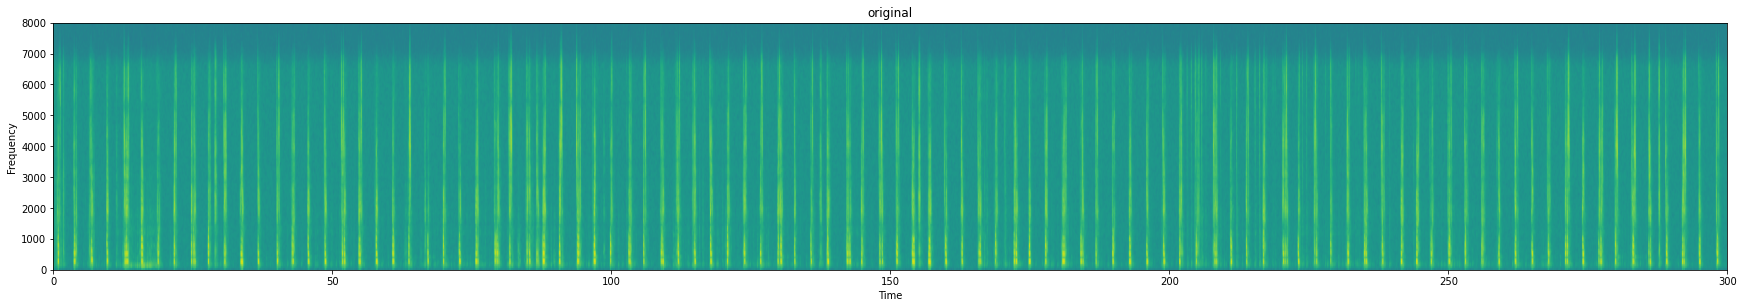

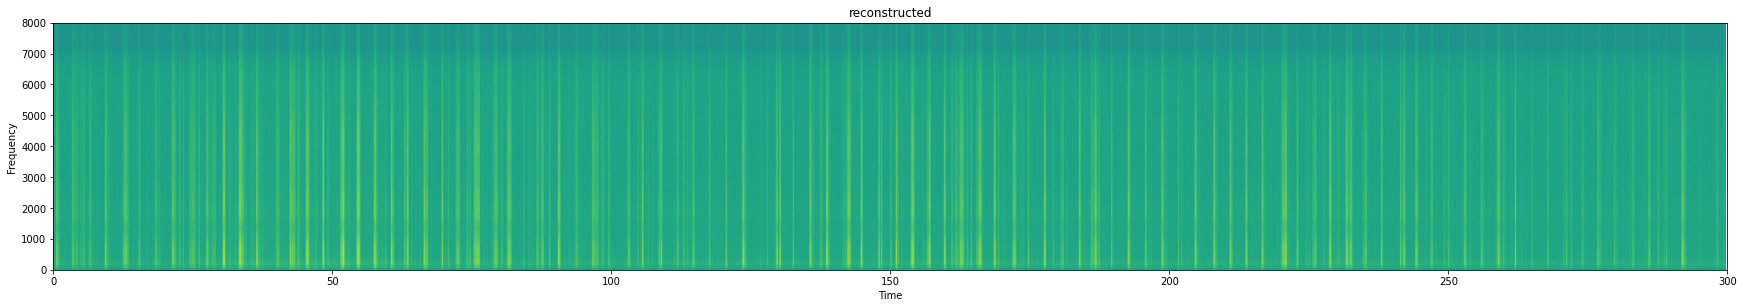

In [ ]:
#from the bottleneck DNN model
#plotting the spectograms of the original sub-o1_orig_audio.wav file and the reconstructed sub-01_predicted.wav file
plt.figure(figsize = (30,10))
plt.subplot(211)
plt.specgram(orig, Fs=16000)
plt.title('original')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.xlim(0,300)  
plt.show()

plt.figure(figsize = (30,10))
plt.subplot(212)
plt.specgram(rec_bn, Fs=16000)
plt.title('reconstructed')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.xlim(0,300)  
plt.show()

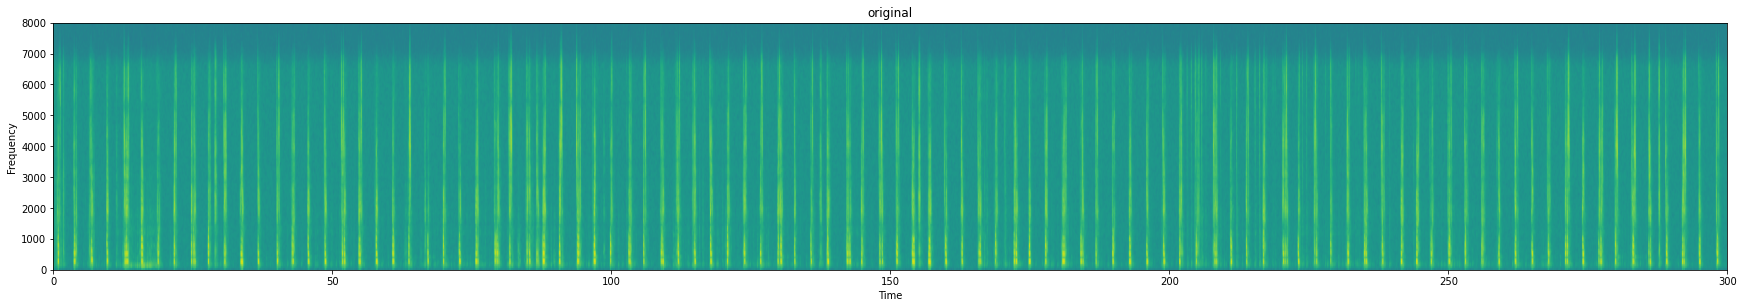

/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_axes.py:7592: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


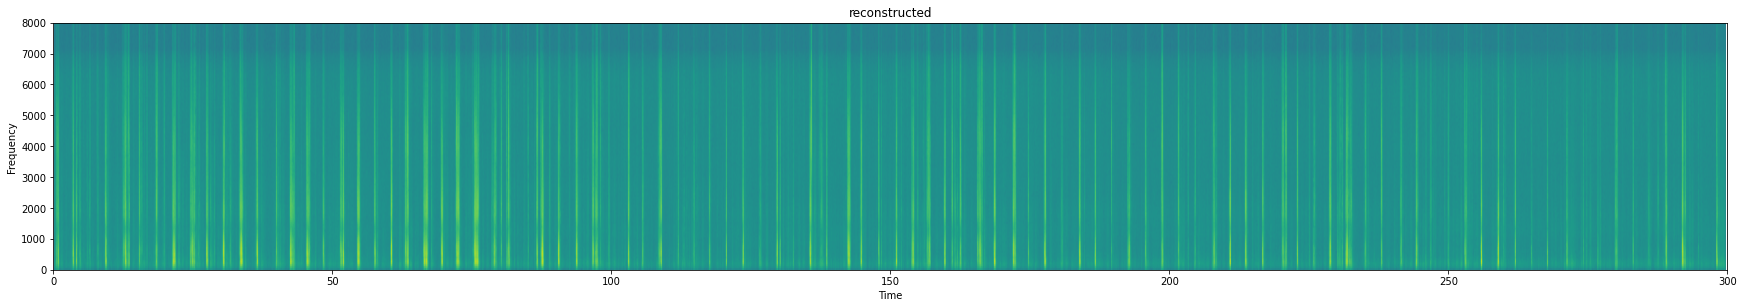

In [ ]:
#from the normal DNN model
#plotting the spectograms of the original sub-o1_orig_audio.wav file and the reconstructed sub-01_predicted.wav file
plt.figure(figsize = (30,10))
plt.subplot(211)
plt.specgram(orig, Fs=16000)
plt.title('original')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.xlim(0,300)  
plt.show()

plt.figure(figsize = (30,10))
plt.subplot(212)
plt.specgram(rec_dnn, Fs=16000)
plt.title('reconstructed')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.xlim(0,300)  
plt.show()

In [ ]:
#from the BiGRU model
#plotting the spectograms of the original sub-o1_orig_audio.wav file and the reconstructed sub-01_predicted.wav file
plt.figure(figsize = (30,10))
plt.subplot(211)
plt.specgram(orig, Fs=16000)
plt.title('original')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.xlim(0,300)  
plt.show()

plt.figure(figsize = (30,10))
plt.subplot(212)
plt.specgram(rec_bigru, Fs=16000)
plt.title('reconstructed')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.xlim(0,300)  
plt.show()

In [ ]:
# From the bottleneck FC-DNN model
compute_mcd('/content/synth_audio_bn/')

Processing -----------sub-01_predicted.wav
mgc of /content/features/sub-01_orig_audio.wav is ok!
mgc of /content/synth_audio_bn/sub-01_predicted.wav is ok!
MCD of sub-01: 7.7355045232373305


In [ ]:
# From the normal FC-DNN model
compute_mcd('/content/synth_audio_dnn/')

Processing -----------sub-01_predicted.wav
mgc of /content/features/sub-01_orig_audio.wav is ok!
mgc of /content/synth_audio_dnn/sub-01_predicted.wav is ok!
MCD of sub-01: 5.058194909458524
Processing -----------.ipynb_checkpoints


FileNotFoundError: ignored

In [ ]:
# From the BiGRU model
compute_mcd('/content/synth_audio_bigru/')

# 2.) Optimizing the baseline one person type models

We are going to use keras tuner for this task.

## Tuning the Bottleneck FC DNN model

In [ ]:
%%capture
!pip install keras-tuner

In [ ]:
import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt
from scipy.stats import pearsonr
from sklearn.model_selection import KFold, train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import scipy.io.wavfile as wavfile

In [ ]:
def create_bottleneck_model_opt(hp):

  '''
  Here we follow the default syntax for hypertuning with keras-tuner.
  For each layer we give an interval and a stepsize for the tuner to choose hyperparameters from.
  The structure has to be close to the original, so the intervals were chosen accordingly.
  '''

  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Input(shape=(200)))

  hp_units_1 = hp.Int('units_1', min_value=128, max_value=256, step=32)
  model.add(tf.keras.layers.Dense(units = hp_units_1, activation="relu", kernel_initializer='HeNormal'))
  model.add(tf.keras.layers.Dropout(rate=hp.Float('dropout_1', min_value = 0.0, max_value = 0.4, default = 0.2, step = 0.05)))

  hp_units_2 = hp.Int('units_2', min_value=64, max_value=96, step=8)
  model.add(tf.keras.layers.Dense(units = hp_units_2, activation="relu", kernel_initializer='HeNormal'))
  model.add(tf.keras.layers.Dropout(rate=hp.Float('dropout_2', min_value = 0.0, max_value = 0.4, default = 0.2, step = 0.05)))

  hp_units_3 = hp.Int('units_3', min_value=16, max_value=32, step=4)
  model.add(tf.keras.layers.Dense(units = hp_units_3, activation="relu", kernel_initializer='HeNormal'))
  model.add(tf.keras.layers.Dropout(rate=hp.Float('dropout_3', min_value = 0.0, max_value = 0.4, default = 0.2, step = 0.05)))

  hp_units_4 = hp.Int('units_4', min_value=4, max_value=8, step=2)
  model.add(tf.keras.layers.Dense(units = hp_units_4, activation="relu", kernel_initializer='HeNormal'))
  model.add(tf.keras.layers.Dropout(rate=hp.Float('dropout_4', min_value = 0.0, max_value = 0.4, default = 0.2, step = 0.05)))

  model.add(tf.keras.layers.Dense(16, activation="relu", kernel_initializer='HeNormal'))
  model.add(tf.keras.layers.Dropout(rate=hp.Float('dropout_5', min_value = 0.0, max_value = 0.4, default = 0.2, step = 0.05)))

  model.add(tf.keras.layers.Dense(23)) #output

  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss='mse',
                metrics=['mse'])
  
  return model

In [ ]:
!rm -r synth_audio_bn_opt   #removing the directory to avoid glitches when rerunning

In [ ]:
!mkdir synth_audio_bn_opt   #making a directory to save the prediction to

In [ ]:
data = np.load(r'/content/features/sub-01_feat.npy')
spectrogram = np.load(r'/content/features/sub-01_spec.npy')

#Inital parameters
nfolds = 5
kf = KFold(nfolds,shuffle=False)
pca = PCA()
numComps = 200
val_split = 0.2

#Audio Reconstruction parameters
winLength = 0.05
frameshift = 0.01
audiosr = 16000

#Initialize an empty spectrogram to save the reconstruction to
rec_spec = np.zeros(spectrogram.shape)
#Save the correlation coefficients for each fold
rs = np.zeros((nfolds,spectrogram.shape[1]))
for k,(train, test) in enumerate(kf.split(data)):
          
    #Train, validation and test data
    X_train_temp = data[train,:]
    y_train_temp = spectrogram[train,:]
    X_train, X_val, y_train, y_val = train_test_split(X_train_temp, y_train_temp, test_size=val_split, random_state=0)
    X_test = data[test,:]
    y_test = spectrogram[test,:] # this one might not be needed
    
    #Standardization
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train[:] = scaler.transform(X_train)
    X_val[:] = scaler.transform(X_val)
    X_test[:] = scaler.transform(X_test)

    #Fit PCA to training data
    pca.fit(X_train)
    #Tranform data 
    X_train = np.dot(X_train, pca.components_[:numComps,:].T)
    X_val = np.dot(X_val, pca.components_[:numComps,:].T)
    X_test = np.dot(X_test, pca.components_[:numComps,:].T)

    # Fine-tuning the parameters
    tuner = kt.Hyperband(create_bottleneck_model_opt,
                         objective='val_loss',
                         max_epochs=10,
                         factor=2,
                         directory='/content/bottleneck_opt' + str(k),
                         project_name='bn_opt' + str(k))
    
    stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
    tuner.search(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_val, y_val), verbose=0, shuffle=True, callbacks=[stop_early])
    best_hps=tuner.get_best_hyperparameters(num_trials=3)[0]

    #Applying the best model
    early_stopping=EarlyStopping(patience=20, verbose=1, min_delta=1e-5)
    checkpointer=ModelCheckpoint(filepath='weights2.hdf5', save_best_only=True, verbose=1)



    model = tuner.hypermodel.build(best_hps)
    #model.compile(loss='mse', optimizer='adam', metrics=['mse'])
    model.fit(X_train, y_train, batch_size=64, 
                     epochs=100, verbose=0, validation_data=(X_val, y_val), shuffle=True,
                     callbacks=[checkpointer, early_stopping])
            
    #predict with the best weights
    model.load_weights('weights2.hdf5')
    rec_spec[test, :] = model.predict(X_test, verbose=0)

    #Evaluate reconstruction of this fold
    for specBin in range(spectrogram.shape[1]):
         r, p = pearsonr(spectrogram[test, specBin], rec_spec[test, specBin])
         rs[k,specBin] = r


#Show evaluation result
print("")
print('Mean correlation:', np.mean(rs))

#Make and save the synthesized audio
reconstructedWav = createAudio(rec_spec,audiosr=audiosr,winLength=winLength,frameshift=frameshift)
wavfile.write(os.path.join('/content/synth_audio_bn_opt/sub-01_predicted.wav'),int(audiosr),reconstructedWav)


Epoch 1: val_loss improved from inf to 1.77328, saving model to weights2.hdf5

Epoch 2: val_loss improved from 1.77328 to 1.72663, saving model to weights2.hdf5

Epoch 3: val_loss improved from 1.72663 to 1.35037, saving model to weights2.hdf5

Epoch 4: val_loss improved from 1.35037 to 1.31259, saving model to weights2.hdf5

Epoch 5: val_loss improved from 1.31259 to 1.13588, saving model to weights2.hdf5

Epoch 6: val_loss improved from 1.13588 to 0.99768, saving model to weights2.hdf5

Epoch 7: val_loss did not improve from 0.99768

Epoch 8: val_loss improved from 0.99768 to 0.92859, saving model to weights2.hdf5

Epoch 9: val_loss did not improve from 0.92859

Epoch 10: val_loss did not improve from 0.92859

Epoch 11: val_loss did not improve from 0.92859

Epoch 12: val_loss improved from 0.92859 to 0.89432, saving model to weights2.hdf5

Epoch 13: val_loss improved from 0.89432 to 0.87747, saving model to weights2.hdf5

Epoch 14: val_loss did not improve from 0.87747

Epoch 15: v

Let's see the result of the tuning.

In [ ]:
orig = load_wav('/content/features/sub-01_orig_audio.wav', 16000)
rec_bn = load_wav('/content/synth_audio_bn_opt/sub-01_predicted.wav', 16000)

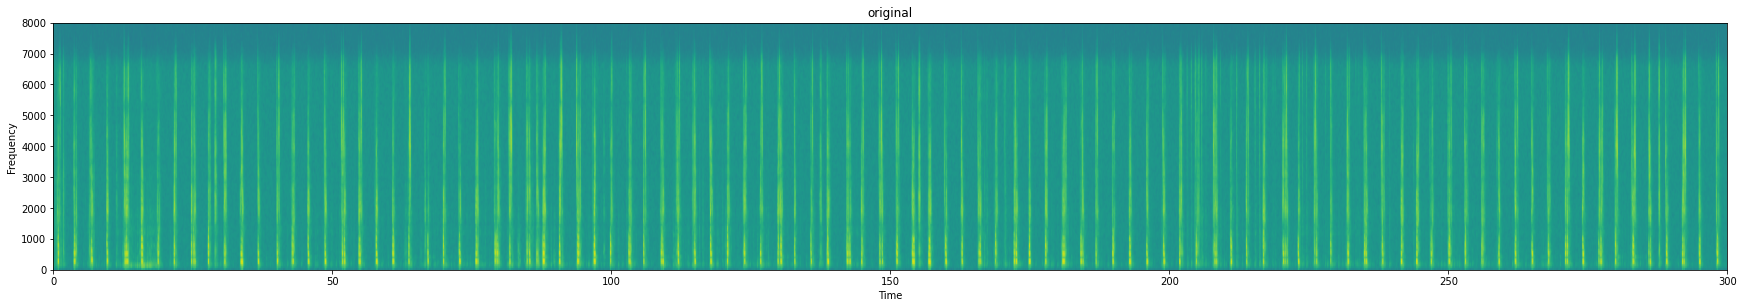

/usr/local/lib/python3.8/dist-packages/matplotlib/axes/_axes.py:7592: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


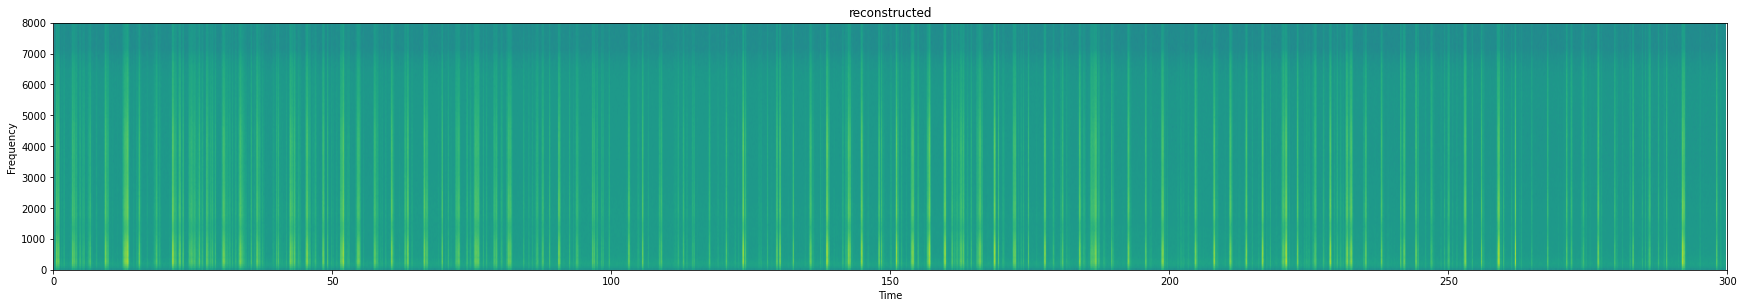

In [ ]:
#from the bottleneck DNN model
#plotting the spectograms of the original sub-o1_orig_audio.wav file and the reconstructed sub-01_predicted.wav file
plt.figure(figsize = (30,10))
plt.subplot(211)
plt.specgram(orig, Fs=16000)
plt.title('original')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.xlim(0,300)  
plt.show()

plt.figure(figsize = (30,10))
plt.subplot(212)
plt.specgram(rec_bn, Fs=16000)
plt.title('reconstructed')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.xlim(0,300)  
plt.show()

In [ ]:
# From the bottleneck FC-DNN model
compute_mcd('/content/synth_audio_bn_opt/')

Processing -----------sub-01_predicted.wav
mgc of /content/features/sub-01_orig_audio.wav is ok!
mgc of /content/synth_audio_bn_opt/sub-01_predicted.wav is ok!
MCD of sub-01: 3.912976628843542


## Tuning the Normal FC DNN model

In [ ]:
def create_dnn_model_opt(hp):  

  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Input(shape=(200)))

  hp_units_1 = hp.Int('units_1', min_value=100, max_value=150, step=10)
  model.add(tf.keras.layers.Dense(units = hp_units_1, activation="relu", kernel_initializer='HeNormal'))
  model.add(tf.keras.layers.Dropout(rate=hp.Float('dropout_1', min_value = 0.0, max_value = 0.2, default = 0.1, step = 0.04)))

  hp_units_2 = hp.Int('units_2', min_value=100, max_value=140, step=10)
  model.add(tf.keras.layers.Dense(units = hp_units_2, activation="relu", kernel_initializer='HeNormal'))
  model.add(tf.keras.layers.Dropout(rate=hp.Float('dropout_2', min_value = 0.0, max_value = 0.2, default = 0.1, step = 0.04)))

  hp_units_3 = hp.Int('units_3', min_value=60, max_value=80, step=5)
  model.add(tf.keras.layers.Dense(units = hp_units_3, activation="relu", kernel_initializer='HeNormal'))
  model.add(tf.keras.layers.Dropout(rate=hp.Float('dropout_3', min_value = 0.0, max_value = 0.2, default = 0.1, step = 0.04)))

  model.add(tf.keras.layers.Dense(40))

  model.add(tf.keras.layers.Dense(23)) #output

  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss='mse',
                metrics=['mse'])
  
  return model

In [ ]:
!rm -r synth_audio_fcdnn_opt  #necessary for rerunning, to avoid glitches when overwriting the reconstructed spectrogram

rm: cannot remove 'synth_audio_fcdnn_opt': No such file or directory


In [ ]:
!mkdir synth_audio_fcdnn_opt

In [ ]:
data = np.load(r'/content/features/sub-01_feat.npy')
spectrogram = np.load(r'/content/features/sub-01_spec.npy')

#Inital parameters
nfolds = 5
kf = KFold(nfolds,shuffle=False)
pca = PCA()
numComps = 200
val_split = 0.2

#Audio Reconstruction parameters
winLength = 0.05
frameshift = 0.01
audiosr = 16000

#Initialize an empty spectrogram to save the reconstruction to
rec_spec = np.zeros(spectrogram.shape)
#Save the correlation coefficients for each fold
rs = np.zeros((nfolds,spectrogram.shape[1]))
for k,(train, test) in enumerate(kf.split(data)):
          
    #Train, validation and test data
    X_train_temp = data[train,:]
    y_train_temp = spectrogram[train,:]
    X_train, X_val, y_train, y_val = train_test_split(X_train_temp, y_train_temp, test_size=val_split, random_state=0)
    X_test = data[test,:]
    y_test = spectrogram[test,:] # this one might not be needed
    
    #Standardization
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train[:] = scaler.transform(X_train)
    X_val[:] = scaler.transform(X_val)
    X_test[:] = scaler.transform(X_test)

    #Fit PCA to training data
    pca.fit(X_train)
    #Tranform data 
    X_train = np.dot(X_train, pca.components_[:numComps,:].T)
    X_val = np.dot(X_val, pca.components_[:numComps,:].T)
    X_test = np.dot(X_test, pca.components_[:numComps,:].T)

    # Fine-tuning the parameters
    tuner2 = kt.Hyperband(create_dnn_model_opt,
                         objective='val_loss',
                         max_epochs=10,
                         factor=2,
                         directory='/content/fcdnn_opt' + str(k),
                         project_name='dnn_opt' + str(k))
    
    stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
    tuner2.search(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_val, y_val), verbose=0, shuffle=True, callbacks=[stop_early])
    best_hps=tuner2.get_best_hyperparameters(num_trials=3)[0]

    #Applying the best model
    early_stopping=EarlyStopping(patience=20, verbose=1, min_delta=1e-5)
    checkpointer=ModelCheckpoint(filepath='weights.hdf5', save_best_only=True, verbose=1)



    model = tuner2.hypermodel.build(best_hps)
    #model.compile(loss='mse', optimizer='adam', metrics=['mse'])
    model.fit(X_train, y_train, batch_size=64, 
                     epochs=100, verbose=0, validation_data=(X_val, y_val), shuffle=True,
                     callbacks=[checkpointer, early_stopping])
            
    #predict with the best weights
    model.load_weights('weights.hdf5')
    rec_spec[test, :] = model.predict(X_test, verbose=0)

    #Evaluate reconstruction of this fold
    for specBin in range(spectrogram.shape[1]):
         r, p = pearsonr(spectrogram[test, specBin], rec_spec[test, specBin])
         rs[k,specBin] = r


#Show evaluation result
print("")
print('Mean correlation:', np.mean(rs))

#Make and save the synthesized audio
reconstructedWav = createAudio(rec_spec,audiosr=audiosr,winLength=winLength,frameshift=frameshift)
wavfile.write(os.path.join('/content/synth_audio_fcdnn_opt/sub-01_predicted.wav'),int(audiosr),reconstructedWav)


Epoch 1: val_loss improved from inf to 2.36634, saving model to weights.hdf5

Epoch 2: val_loss improved from 2.36634 to 2.25802, saving model to weights.hdf5

Epoch 3: val_loss improved from 2.25802 to 1.92338, saving model to weights.hdf5

Epoch 4: val_loss improved from 1.92338 to 1.65101, saving model to weights.hdf5

Epoch 5: val_loss improved from 1.65101 to 1.40054, saving model to weights.hdf5

Epoch 6: val_loss improved from 1.40054 to 1.16384, saving model to weights.hdf5

Epoch 7: val_loss improved from 1.16384 to 1.05602, saving model to weights.hdf5

Epoch 8: val_loss improved from 1.05602 to 0.90887, saving model to weights.hdf5

Epoch 9: val_loss did not improve from 0.90887

Epoch 10: val_loss did not improve from 0.90887

Epoch 11: val_loss improved from 0.90887 to 0.74971, saving model to weights.hdf5

Epoch 12: val_loss improved from 0.74971 to 0.71183, saving model to weights.hdf5

Epoch 13: val_loss improved from 0.71183 to 0.70281, saving model to weights.hdf5

E

In [ ]:
rec_dnn = load_wav('/content/synth_audio_fcdnn_opt/sub-01_predicted.wav', 16000)

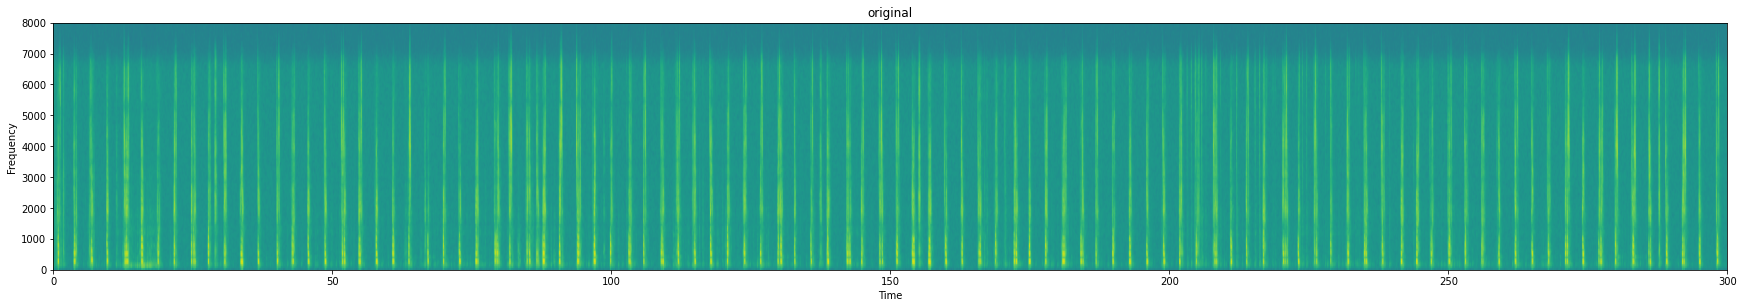

/usr/local/lib/python3.8/dist-packages/matplotlib/axes/_axes.py:7592: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


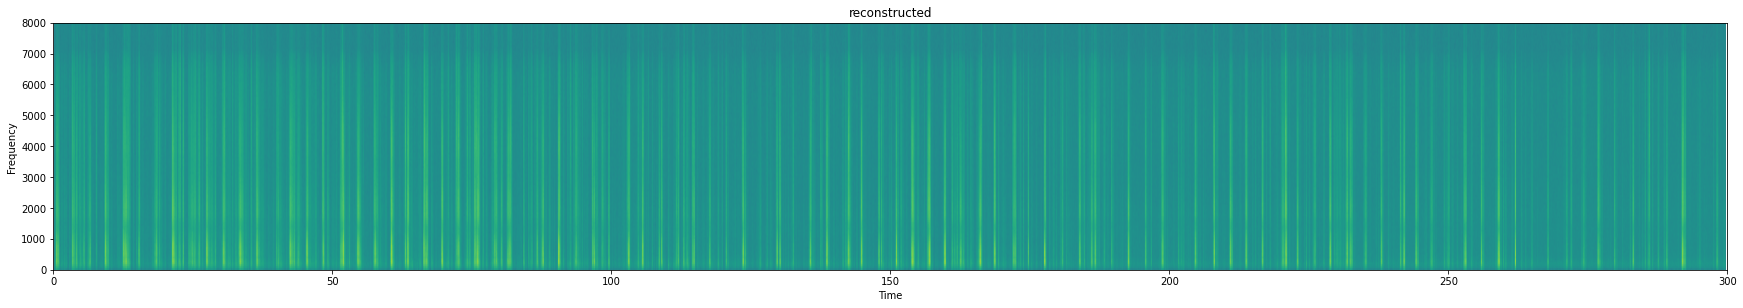

In [ ]:
#from the bottleneck DNN model
#plotting the spectograms of the original sub-o1_orig_audio.wav file and the reconstructed sub-01_predicted.wav file
plt.figure(figsize = (30,10))
plt.subplot(211)
plt.specgram(orig, Fs=16000)
plt.title('original')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.xlim(0,300)  
plt.show()

plt.figure(figsize = (30,10))
plt.subplot(212)
plt.specgram(rec_dnn, Fs=16000)
plt.title('reconstructed')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.xlim(0,300)  
plt.show()

In [ ]:
# From the bottleneck FC-DNN model
compute_mcd('/content/synth_audio_fcdnn_opt/')

Processing -----------sub-01_predicted.wav
mgc of /content/features/sub-01_orig_audio.wav is ok!
mgc of /content/synth_audio_fcdnn_opt/sub-01_predicted.wav is ok!
MCD of sub-01: 5.882117239208088


## Tuning the BiGRU model

In [ ]:
def create_bigru_model(channels, outputsize):
  model = tf.keras.Sequential()
  model.add(Input(shape=(9, channels)))
  model.add(Bidirectional(GRU(units=100, return_sequences=True, dropout=0.2)))
  model.add(Bidirectional(GRU(units=50, return_sequences=True, dropout=0.2)))
  model.add(Flatten())
  model.add(Dense(outputsize))
  return model

def create_bigru_model_opt(channels, outputsize, hp):
  model = tf.keras.Sequential()
  model.add(Input(shape=(9, channels)))
  model.add(Bidirectional(GRU(units=hp.Choice('units_1', [90, 100, 110, 120]), return_sequences=True, dropout=hp.Float('dropout_1', min_value = 0.0, max_value = 0.4, default = 0.2, step = 0.05)))))
  model.add(Bidirectional(GRU(units=hp.Choice('units_2', [45, 50, 55, 60]), return_sequences=True, dropout=hp.Float('dropout_2', min_value = 0.0, max_value = 0.4, default = 0.2, step = 0.05)))))
  model.add(Flatten())
  model.add(Dense(outputsize))

  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss='mse',
                metrics=['mse'])
  return model

In [ ]:
data = np.load(r'/content/features/sub-01_feat.npy')
spectrogram = np.load(r'/content/features/sub-01_spec.npy')

#Inital parameters for prediction
nfolds = 5
kf = KFold(nfolds,shuffle=False)
pca = PCA()
val_split = 0.2

#Audio Reconstruction parameters
winLength = 0.05
frameshift = 0.01
audiosr = 16000


#Initialize an empty spectrogram to save the reconstruction to
rec_spec = np.zeros(spectrogram.shape)
#Save the correlation coefficients for each fold
rs = np.zeros((nfolds,spectrogram.shape[1]))
for k,(train, test) in enumerate(kf.split(data)):
          
    #Train, validation and test data
    X_train_temp = data[train,:]
    y_train_temp = spectrogram[train,:]
    X_train, X_val, y_train, y_val = train_test_split(X_train_temp, y_train_temp, test_size=val_split, random_state=0)
    X_test = data[test,:]
    y_test = spectrogram[test,:] # this one might not be needed
    
    #Standardization
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train[:] = scaler.transform(X_train)
    X_val[:] = scaler.transform(X_val)
    X_test[:] = scaler.transform(X_test)

    #We don't use PCA here

    X_train = bigru_reshape(X_train)
    X_val = bigru_reshape(X_val)
    X_test = bigru_reshape(X_test)


    early_stopping=EarlyStopping(patience=25, verbose=1, min_delta=1e-5)
    checkpointer=ModelCheckpoint(filepath='weights1.hdf5', save_best_only=True, verbose=1)

############################################

    tuner3 = kt.Hyperband(create_bigru_model_opt,
                         objective='val_loss',
                         max_epochs=10,
                         factor=2,
                         directory='/content/fcdnn_opt' + str(k),
                         project_name='dnn_opt' + str(k))
    
    stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
    tuner2.search(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_val, y_val), verbose=0, shuffle=True, callbacks=[stop_early])
    best_hps=tuner2.get_best_hyperparameters(num_trials=3)[0]

    #Applying the best model
    early_stopping=EarlyStopping(patience=20, verbose=1, min_delta=1e-5)
    checkpointer=ModelCheckpoint(filepath='weights.hdf5', save_best_only=True, verbose=1)



    model = tuner2.hypermodel.build(best_hps)
    #model.compile(loss='mse', optimizer='adam', metrics=['mse'])
    model.fit(X_train, y_train, batch_size=64, 
                     epochs=100, verbose=0, validation_data=(X_val, y_val), shuffle=True,
                     callbacks=[checkpointer, early_stopping])
            
    #predict with the best weights
    model.load_weights('weights.hdf5')
    rec_spec[test, :] = model.predict(X_test, verbose=0)




############################x
    model = create_bigru_model(X_train.shape[2], spectrogram.shape[1])
    #model.compile(loss='mse', optimizer='adam', metrics=['mse'])
    model.fit(X_train, y_train, batch_size=64, 
              epochs=100, verbose=0, validation_data=(X_val, y_val), shuffle=True,
              callbacks=[checkpointer, early_stopping])
            
    #predict with the best weights
    model.load_weights('weights1.hdf5')
    rec_spec[test, :] = model.predict(X_test, verbose=0)


    #Evaluate reconstruction of this fold
    for specBin in range(spectrogram.shape[1]):
         r, p = pearsonr(spectrogram[test, specBin], rec_spec[test, specBin])
         rs[k,specBin] = r


#Show evaluation result
print("")
print('Mean correlation:', np.mean(rs))


#Make and save the synthesized audio
reconstructedWav = createAudio(rec_spec,audiosr=audiosr,winLength=winLength,frameshift=frameshift)
wavfile.write(os.path.join('/content/synth_audio_bigru/sub-01_predicted.wav'),int(audiosr),reconstructedWav)

# 3.) Trying out the best configuration for every subject

In [ ]:
# from scipy.stats import pearsonr
# from sklearn.model_selection import KFold, train_test_split
# from sklearn.decomposition import PCA
# from sklearn.preprocessing import StandardScaler
# import scipy.io.wavfile as wavfile
# ##### MODELING ########

# # So far, the best performance came from the normal DNN model

# model = True

# scores= []

# if model == True:
#     feat_path = r'/content/features'
#     result_path = r'/content/synth_audio'
#     pts = ['sub-%02d'%i for i in range(1,11)]

#     winLength = 0.05
#     frameshift = 0.01
#     audiosr = 16000

#     nfolds = 10
#     kf = KFold(nfolds,shuffle=False)
#     pca = PCA()
#     numComps = 50
    

#     for pNr, pt in enumerate(pts):
        
        
#         #Load the data
#         #Dimensions of these data vary depending on the subject
#         spectrogram = np.load(os.path.join(feat_path,f'{pt}_spec.npy'))  
#         data = np.load(os.path.join(feat_path,f'{pt}_feat.npy'))

        
#         #Initialize an empty spectrogram to save the reconstruction to
#         rec_spec = np.zeros(spectrogram.shape)
#         #Save the correlation coefficients for each fold
#         rs = np.zeros((nfolds,spectrogram.shape[1]))
#         for k,(train, test) in enumerate(kf.split(data)):
          
#             #Train, validation and test data
#             X_train_temp = data[train,:]
#             y_train_temp = spectrogram[train,:]
#             X_train, X_val, y_train, y_val = train_test_split(X_train_temp, y_train_temp, test_size=val_split, random_state=0)
#             X_test = data[test,:]
#             y_test = spectrogram[test,:] # this one might not be needed
            
#             #Standardization
#             scaler = StandardScaler()
#             scaler.fit(X_train)
#             X_train[:] = scaler.transform(X_train)
#             X_val[:] = scaler.transform(X_val)
#             X_test[:] = scaler.transform(X_test)


#             #Fit PCA to training data
#             pca.fit(X_train)
#             #Tranform data 
#             X_train = np.dot(X_train, pca.components_[:numComps,:].T)
#             X_val = np.dot(X_val, pca.components_[:numComps,:].T)
#             X_test = np.dot(X_test, pca.components_[:numComps,:].T)

#             # normal DNN model
#             early_stopping=EarlyStopping(patience=25, verbose=0, min_delta=1e-5)
#             checkpointer=ModelCheckpoint(filepath='weights1.hdf5', save_best_only=True, verbose=0)

#             model = create_simple_model(numComps, spectrogram.shape[1])
#             model.compile(loss='mse', optimizer='adam', metrics=['mse'])
#             model.fit(X_train, y_train, batch_size=64, 
#                       epochs=100, verbose=0, validation_data=(X_val, y_val), shuffle=True,
#                       callbacks=[checkpointer, early_stopping])
                    
#             #predict with the best weights
#             model.load_weights('weights1.hdf5')
#             rec_spec[test, :] = model.predict(X_test, verbose=0)

#             #Evaluate reconstruction of this fold
#             for specBin in range(spectrogram.shape[1]):
#                 if np.any(np.isnan(rec_spec)):
#                     print('%s has %d broken samples in reconstruction' % (pt, np.sum(np.isnan(rec_spec))))
#                 r, p = pearsonr(spectrogram[test, specBin], rec_spec[test, specBin])
#                 rs[k,specBin] = r

#         #Show evaluation result
#         print('%s has mean correlation of %f' % (pt, np.mean(rs)))
#         scores.append(np.mean(rs))


#         #Make and save the synthesized audio
#         reconstructedWav = createAudio(rec_spec,audiosr=audiosr,winLength=winLength,frameshift=frameshift)
#         wavfile.write(os.path.join('/content/synth_audio/',f'{pt}_predicted.wav'),int(audiosr),reconstructedWav)
        
# # MCD score for the subjects
# compute_mcd('/content/synth_audio/')